# Thermodynamic framework for EVo

This is a thermodynamic framework developed by Kilbride et al. (2016) and refined by Yip et al. (2022).

This notebook processes output from EVo thermodynamic model (Liggins et al., 2020, 2021) to: 
- visualise magma properties as a function of depth (e.g., volatile content in melt, gas volume fraction, density) 
- calculate observable parameters (e.g., SO₂, volume change and displacement, all normalised by per unit volume erupted)

EVo thermodynamic model: https://github.com/pipliggins/EVo

For more information, see:
- Liggins et al. 2020 (https://doi.org/10.1016/j.epsl.2020.116546) 
- Liggins et al., 2021 (https://arxiv.org/abs/2111.05161) 
- Yip et al., 2022 (https://doi.org/10.1029/2022GC010387) 

# Table of Contents

* [1. Initialise notebook](#Initialisenotebook)
* [2. Sensitivity Test](#Sensitivitytest)
* [3. Monte-Carlo simulation](#MCSim)
* [4. Observed eruptions](#Obs)

## 1. Initialise notebook <a class="anchor" id="Initialisenotebook"></a>

In [1]:
# Set directory
home_dir = input(f"Set home directory (e.g., C:\\Users\\JohnSmith\\G3_EVo_framework\\): \n") 

Set home directory (e.g., C:\Users\JohnSmith\G3_EVo_framework\): 
C:\\Users\\JohnSmith\\G3_EVo_framework\\


In [2]:
# Import packages
import os
import sys
import statistics
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from IPython.display import display, Markdown, Latex
from math import exp, pi
from pandas import Series, DataFrame


In [3]:
# Define functions
# find nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# sensitivity figure with 8 panels
def plot8_sensitivity(
    Pbar1,Pbar2,Pbar3,
    depth1,depth2,depth3,
    min_percolation1,min_percolation2,min_percolation3,res_depth,
    H2O_melt1,CO2_melt1,Stot_melt1,
    H2O_gas1,CO2_gas1,SO2_gas1,
    mS_released1,Exsolv_vol_wt1,RhoBulk1,
    beta_bulk1,rv_bulk1,z_bulk1,
    H2O_melt2,CO2_melt2,Stot_melt2,
    H2O_gas2,CO2_gas2,SO2_gas2,
    mS_released2,Exsolv_vol_wt2,RhoBulk2,
    beta_bulk2,rv_bulk2,z_bulk2,
    H2O_melt3,CO2_melt3,Stot_melt3,
    H2O_gas3,CO2_gas3,SO2_gas3,
    mS_released3,Exsolv_vol_wt3,RhoBulk3,
    beta_bulk3,rv_bulk3,z_bulk3):
    
    rv1 = df_calc[1]['beta_bulk']
    rv2 = df_calc[2]['beta_bulk'] 
    rv3 = df_calc[3]['beta_bulk'] 
    
    fig = plt.figure(figsize=(12, 10), dpi=80)

    # Dissolved magmatic volatile
    ax1 = fig.add_subplot(2, 4, 1)
    ax2 = ax1.twinx()
    ax1.plot(H2O_melt1[0:int(min_percolation1)], Pbar1[0:int(min_percolation1)]/10, c='k', label=sensitivity1)
    ax1.plot(H2O_melt2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)]/10, c='k', label=sensitivity2, linestyle = 'dashed')
    ax1.plot(H2O_melt3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)]/10, c='k', label=sensitivity3, linestyle = 'dotted')
    ax1.legend(loc='lower left')
    ax1.plot(H2O_melt1[0:int(min_percolation1)], Pbar1[0:int(min_percolation1)]/10, c='r')
    ax1.plot(CO2_melt1[0:int(min_percolation1)], Pbar1[0:int(min_percolation1)]/10, c='b')
    ax1.plot(Stot_melt1[0:int(min_percolation1)],Pbar1[0:int(min_percolation1)]/10, c='g')
    ax1.plot(H2O_melt1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1]/10, c='silver')
    ax1.plot(CO2_melt1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1]/10, c='silver')
    ax1.plot(Stot_melt1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1]/10, c='silver')
    ax1.plot(H2O_melt2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)]/10, c='r', linestyle = 'dashed')
    ax1.plot(CO2_melt2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)]/10, c='b', linestyle = 'dashed')
    ax1.plot(Stot_melt2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)]/10, c='g', linestyle = 'dashed')    
    ax1.plot(H2O_melt2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1]/10, c='silver', linestyle = 'dashed')
    ax1.plot(CO2_melt2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1]/10, c='silver', linestyle = 'dashed')
    ax1.plot(Stot_melt2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1]/10, c='silver', linestyle = 'dashed')
    ax1.plot(H2O_melt3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)]/10, c='r', linestyle = 'dotted')
    ax1.plot(CO2_melt3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)]/10, c='b', linestyle = 'dotted')
    ax1.plot(Stot_melt3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)]/10, c='g', linestyle = 'dotted')    
    ax1.plot(H2O_melt3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1]/10, c='silver', linestyle = 'dotted')
    ax1.plot(CO2_melt3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1]/10, c='silver', linestyle = 'dotted')
    ax1.plot(Stot_melt3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1]/10, c='silver', linestyle = 'dotted')
    ax1.set_xlabel('Volatile in melt,\n$w^x_{M}$ (wt%)')
    ax1.set_ylabel('Pressure (MPa)')
    ax1.set_xlim(0.0001, 20)
    ax1.set_xscale('log')
    ax1.set_ylim((Pbar3.iloc[-1]-27.45)/10, Pbar3.iloc[0]/10)
    ax1.invert_yaxis()
    ax2.set_ylim(depth3.iloc[-1]-0.1,depth3.iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
    ax1.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
    ax1.xaxis.set_minor_locator(locmin)
    ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax2.set_yticks([])
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
    textstr = 'a)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    # Exsolved volatile
    ax1 = fig.add_subplot(2, 4, 2)
    ax2 = ax1.twinx()
    ax1.plot(H2O_gas1[0:int(min_percolation1)], Pbar1[0:int(min_percolation1)], c='r', label='H$_2$O')
    ax1.plot(CO2_gas1[0:int(min_percolation1)], Pbar1[0:int(min_percolation1)], c='b', label='CO$_2$')
    ax1.plot(SO2_gas1[0:int(min_percolation1)], Pbar1[0:int(min_percolation1)], c='g', label='SO$_2$')
    ax1.plot(H2O_gas1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1], c='silver')
    ax1.plot(CO2_gas1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1], c='silver')
    ax1.plot(SO2_gas1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1], c='silver')
    ax1.plot(H2O_gas2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)], c='r', linestyle = 'dashed')
    ax1.plot(CO2_gas2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)], c='b', linestyle = 'dashed')
    ax1.plot(SO2_gas2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)], c='g', linestyle = 'dashed')
    ax1.plot(H2O_gas2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1], c='silver', linestyle = 'dashed')
    ax1.plot(CO2_gas2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1], c='silver', linestyle = 'dashed')
    ax1.plot(SO2_gas2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1], c='silver', linestyle = 'dashed')
    ax1.plot(H2O_gas3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)], c='r', linestyle = 'dotted')
    ax1.plot(CO2_gas3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)], c='b', linestyle = 'dotted')
    ax1.plot(SO2_gas3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)], c='g', linestyle = 'dotted')
    ax1.plot(H2O_gas3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1], c='silver', linestyle = 'dotted')
    ax1.plot(CO2_gas3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1], c='silver', linestyle = 'dotted')
    ax1.plot(SO2_gas3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1], c='silver', linestyle = 'dotted')
    ax1.set_xlabel('Volatile in gas,\n$m^x_{g}$ (mol%)')
    ax1.set_xlim(0.000001, 20)
    ax1.set_xscale('log')
    ax1.set_ylim(Pbar3.iloc[-1]-27.45, Pbar3.iloc[0])
    ax1.invert_yaxis()
    ax2.set_ylim(depth3.iloc[-1]-0.1,depth3.iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
    ax1.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
    ax1.xaxis.set_minor_locator(locmin)
    ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax1.set_yticks([])
    ax2.set_yticks([])
    textstr = 'b)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

    # Normalised SO2
    ax1 = fig.add_subplot(2, 4, 3)
    ax2 = ax1.twinx()
    ax1.plot(mS_released1[0:int(min_percolation1)], Pbar1[0:int(min_percolation1)], c='k')
    ax1.plot(mS_released2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)], c='k', linestyle = 'dashed')
    ax1.plot(mS_released3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)], c='k', linestyle = 'dotted')
    ax1.plot(mS_released1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1], c='silver')
    ax1.plot(mS_released2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1], c='silver', linestyle = 'dashed')
    ax1.plot(mS_released3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1], c='silver', linestyle = 'dotted')
    ax1.set_xlabel('Normalised $\mathrm{SO_2}$,\n' + r'$\overline{S}$ (kg$\,$m$^{-3}$)')
    ax1.set_ylim(Pbar3.iloc[-1]-27.45, Pbar3.iloc[0])
    ax1.invert_yaxis()
    ax2.set_ylim(depth3.iloc[-1]-0.1,depth3.iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
#     ax2.axvline(x=0.1, color='red', alpha=0.5)
#     ax2.axvline(x=1, color='green', alpha=0.5)
#     ax2.axvline(x=10, color='blue', alpha=0.5)
    ax2.invert_yaxis()
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax1.set_xlim(-1, 11)
    textstr = 'c)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    # Total exsolved volatiles
    ax1 = fig.add_subplot(2, 4, 4)
    ax2 = ax1.twinx()
    ax1.plot(Exsolv_vol_wt1[0:int(min_percolation1)], Pbar1[0:int(min_percolation1)], c='k')
    ax1.plot(Exsolv_vol_wt2[0:int(min_percolation2)], Pbar2[0:int(min_percolation2)], c='k', linestyle = 'dashed')
    ax1.plot(Exsolv_vol_wt3[0:int(min_percolation3)], Pbar3[0:int(min_percolation3)], c='k', linestyle = 'dotted')
    ax1.plot(Exsolv_vol_wt1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1], c='silver')
    ax1.plot(Exsolv_vol_wt2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1], c='silver', linestyle = 'dashed')
    ax1.plot(Exsolv_vol_wt3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1], c='silver', linestyle = 'dotted')
    ax1.set_xlabel('Total exsolved\ngas, $V_{g}$ (vol%)')
    ax1.set_ylim(Pbar3.iloc[-1]-27.45, Pbar3.iloc[0])
    ax1.invert_yaxis()
    ax2.set_ylim(depth3.iloc[-1]-0.1,depth3.iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(25))
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
    ax2.set_ylabel('Depth (km)')
    ax1.set_xlim(-10, 110)
    ax1.set_yticks([])
    textstr = 'd)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

    # Density
    ax1 = fig.add_subplot(2, 4, 5)
    ax2 = ax1.twinx()
    ax1.plot(RhoBulk1[1:int(min_percolation1)], Pbar1[1:int(min_percolation1)]/10, c='k')
    ax1.plot(RhoBulk1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1]/10, c='silver')
    ax1.plot(RhoBulk2[1:int(min_percolation2)], Pbar2[1:int(min_percolation2)]/10, c='k', linestyle = 'dashed')
    ax1.plot(RhoBulk2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1]/10, c='silver', linestyle = 'dashed')
    ax1.plot(RhoBulk3[1:int(min_percolation3)], Pbar3[1:int(min_percolation3)]/10, c='k', linestyle = 'dotted')
    ax1.plot(RhoBulk3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1]/10, c='silver', linestyle = 'dotted')
    ax1.set_xlabel('Magma density,\n' + r'$\rho_{m}$ (kg$\,$m$^{-3}$)')
    ax1.set_ylabel('Pressure (MPa)')
    ax1.set_ylim((Pbar3.iloc[-1]-27.45)/10, Pbar3.iloc[0]/10)
    ax1.invert_yaxis()
    ax2.set_ylim(depth3.iloc[-1]-0.1,depth3.iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1250))
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(625))
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
    ax1.set_xlim(-100, 2800)
    ax2.set_yticks([])
    textstr = 'e)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    # Compressibility
    ax1 = fig.add_subplot(2, 4, 6)
    ax2 = ax1.twinx()
    ax1.plot(beta_bulk1[1:int(min_percolation1):10], Pbar1[1:int(min_percolation1):10], c='k')
    ax1.plot(beta_bulk1[int(min_percolation1):-1:10], Pbar1[int(min_percolation1):-1:10], c='silver')
    ax1.plot(beta_bulk2[1:int(min_percolation2):10], Pbar2[1:int(min_percolation2):10], c='k',linestyle ='dashed')
    ax1.plot(beta_bulk2[int(min_percolation2):-1:10], Pbar2[int(min_percolation2):-1:10], c='silver',linestyle ='dashed')
    ax1.plot(beta_bulk3[1:int(min_percolation3):10], Pbar3[1:int(min_percolation3):10], c='k',linestyle ='dotted')
    ax1.plot(beta_bulk3[int(min_percolation3):-1:10], Pbar3[int(min_percolation3):-1:10], c='silver',linestyle ='dotted')
    ax1.set_xlabel('Magma\ncompressibility,\n' + r'$\beta_{m}$ (Pa$^{-1}$)')
    ax1.set_xscale('log')
    ax1.set_xlim(0.00000000001, 0.0001)
    ax1.set_ylim(Pbar3.iloc[-1]-27.45, Pbar3.iloc[0])
    ax1.invert_yaxis()
    ax2.set_ylim(depth3.iloc[-1]-0.1,depth3.iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
    ax1.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
    ax1.xaxis.set_minor_locator(locmin)
    ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
    ax1.set_yticks([])
    ax2.set_yticks([])
    rect = mpl.patches.Rectangle((0.00000000001,depth3.iloc[0]), 0.0001+0.00000000001, 25-depth3.iloc[0], linewidth=1, edgecolor='gray', facecolor='gray', zorder=3, alpha = 0.9)
    ax2.add_patch(rect)
    textstr = 'f)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

    # Normalised volume change
    ax1 = fig.add_subplot(2, 4, 7)
    ax2 = ax1.twinx()
    ax1.plot(1/rv_bulk1[1:int(min_percolation1):10], Pbar1[1:int(min_percolation1):10], c='k')
    ax1.plot(1/rv_bulk1[int(min_percolation1):-1:10], Pbar1[int(min_percolation1):-1:10], c='silver')
    ax1.plot(1/rv_bulk2[1:int(min_percolation2):10], Pbar2[1:int(min_percolation2):10], c='k',linestyle ='dashed')
    ax1.plot(1/rv_bulk2[int(min_percolation2):-1:10], Pbar2[int(min_percolation2):-1:10], c='silver',linestyle ='dashed')
    ax1.plot(1/rv_bulk3[1:int(min_percolation3):10], Pbar3[1:int(min_percolation3):10], c='k',linestyle ='dotted')
    ax1.plot(1/rv_bulk3[int(min_percolation3):-1:10], Pbar3[int(min_percolation3):-1:10], c='silver',linestyle ='dotted')
    ax1.set_xlabel('Normalised\nvolume change,\n$\overline{V}$')
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_ylim(Pbar3.iloc[-1]-27.45, Pbar3.iloc[0])
    ax1.invert_yaxis()
    ax2.set_ylim(depth3.iloc[-1]-0.1,depth3.iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
    ax1.set_yticks([])
    ax2.set_yticks([])
    rect = mpl.patches.Rectangle((-0.1,depth3.iloc[0]), 1.2, 25-depth3.iloc[0], linewidth=1, edgecolor='gray', facecolor='gray', zorder=3, alpha = 0.9)
    ax2.add_patch(rect)
    textstr = 'g)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    # Normalised displacement
    ax1 = fig.add_subplot(2, 4, 8)
    ax2 = ax1.twinx()
    ax1.plot(z_bulk1[1:int(min_percolation1)], Pbar1[1:int(min_percolation1)], c='k')
    ax1.plot(z_bulk1[int(min_percolation1):-1], Pbar1[int(min_percolation1):-1], c='silver')
    ax1.plot(z_bulk2[1:int(min_percolation2)], Pbar2[1:int(min_percolation2)], c='k', linestyle = 'dashed')
    ax1.plot(z_bulk2[int(min_percolation2):-1], Pbar2[int(min_percolation2):-1], c='silver', linestyle = 'dashed')
    ax1.plot(z_bulk3[1:int(min_percolation3)], Pbar3[1:int(min_percolation3)], c='k', linestyle = 'dotted')
    ax1.plot(z_bulk3[int(min_percolation3):-1], Pbar3[int(min_percolation3):-1], c='silver', linestyle = 'dotted')
    ax1.set_xlabel('Normalised\ndisplacement,\n$\overline{z}$ (m$\,$km$^{-3}$)')
    ax1.set_xlim(-0.5, 20.5)
    ax1.set_ylim(Pbar3.iloc[-1]-27.45, Pbar3.iloc[0])
    ax1.invert_yaxis()
    ax2.set_ylim(depth3.iloc[-1]-0.1,depth3.iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
    ax1.set_yticks([])
    ax2.set_ylabel('Depth (km)')
    rect = mpl.patches.Rectangle((-0.5,depth3.iloc[0]), 7, 25-depth3.iloc[0], linewidth=1, edgecolor='gray', facecolor='gray', zorder=3, alpha = 0.9)
    ax2.add_patch(rect)
    textstr = 'h)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    

## 2. Sensitivity test <a class="anchor" id="Sensitivitytest"></a>

In [7]:
# Set constants
magma_comp = 'basalt'
shear_modulus = 2100000000
erupted_rock_density = 2800
unit_vol = 1e9
magma_temp = 1473.15 

In [5]:
# Set parameter space to explore
p_space = input(f"Select parameter space ('H2O', 'CO2', 'S', 'fO2', 'Crustal'): \n")
for i in range(0, len(p_space)):
    if p_space == p_space:
        print('\nExploring effects of ' + p_space + ':\n')
        break
    elif i == len(p_space) - 1:
        sys.exit("Error: please select the correct parameter")

# Explore parameter space
if p_space == 'H2O' or p_space == 'CO2' or p_space == 'S' or p_space == 'fO2':
# Read in files from EVo and do calculations
    for i in range(1, 4):
        dcomp_data = home_dir + f"{p_space}_{i}.csv"
        dcomp_calc = home_dir + f"E_{p_space}_{i}_calc.txt"
        df = pd.read_csv(dcomp_data, sep='\t', skiprows=8)
        print(f"Simulating {p_space} {i}")

        # Calculate wt% of volatiles in gas
        H2Ogas = df['wH2O'] * df['Gas_wt']   #change fraction to wt%
        CO2gas = df['wCO2'] * df['Gas_wt'] 
        SO2gas = df['wSO2'] * df['Gas_wt'] 
        H2Sgas = df['wH2S'] * df['Gas_wt'] 

        # Calculate mol% of volatiles in gas
        mH2Ogas = df['mH2O']* df['Gas_wt'] 
        mCO2gas = df['mCO2']* df['Gas_wt'] 
        mSO2gas = df['mSO2']* df['Gas_wt'] 
        mS2gas = df['mS2']* df['Gas_wt'] 
        mH2Sgas = df['mH2S']* df['Gas_wt'] 

        # Calculate wt% of dissolved SO2 
        SO2_melt = df['Stot_melt'] * 64 / 32

        # Calculate wt% of Sulfur in gas
        Sgas1 = []
        k = -1
        for i in range(0, len(df['rho_bulk'])):
            k = k + 1
            Sgas2 = (SO2gas[i] / 64 * 32) + (H2Sgas[i] / 34 * 32)
            Sgas1.append(Sgas2)
        Sgas = np.array(Sgas1)

        #Total moles in 1 m3 magma
        tot_mol_1m3magma = erupted_rock_density * (df['Gas_wt']/100) / df['mol_mass']

        #Volume of fluid in 1 m3 magma
        vol_fluid_1m3magma = tot_mol_1m3magma * 8.31 * magma_temp / (df['P'] * 100000)

        #Mass of SO2 released in 1 m3 magma (kg)
        mS_released = df['mSO2'] * tot_mol_1m3magma * 0.064
        mSulfur_released = (df['mSO2'] * tot_mol_1m3magma * 0.032) + (df['mS2'] * tot_mol_1m3magma * 0.032) + (df['mH2S'] * tot_mol_1m3magma * 0.032)

        #Depth (km)
        depth = df['P'] * 100 / (erupted_rock_density * 9.8)

        #alpha (fluid vol%)
        alpha = vol_fluid_1m3magma * 100

        # Magma compressibility
        dd_dp1 = []  #Change of density with pressure
        k = 0
        for i in range(0, len(df['rho_bulk'])):
            if i == len(df['rho_bulk']) - 1:
                break
            k = k + 1
            dd_dp2 = ((df['rho_bulk'][k - 1] - df['rho_bulk'][k]) /
                      ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
            dd_dp1.append(dd_dp2)
        dd_dp1.insert(0, np.nan)
        dd_dp_bulk = np.array(dd_dp1)

        beta1 = []  #Compressibility = 1/magma density * dd_dp
        for i in range(0, len(df['rho_bulk']) - 1):
            beta2 = ((dd_dp_bulk[i] / df['rho_bulk'][i + 1]))
            beta1.append(beta2)
        beta1[0] = np.nan
        beta1.append(np.nan)
        beta_bulk = np.array(beta1)

        rv1 = []
        for i in range(0, len(beta_bulk)):
            rv2 = ((1 + ((4 * shear_modulus * beta_bulk[i]) / 3)))
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_bulk = np.array(rv1)

        # Melt compressibility
        dd_dp1 = []  #Change of density with pressure
        k = 0
        for i in range(0, len(df['rho_melt'])):
            if i == len(df['rho_melt']) - 1:
                break
            k = k + 1
            dd_dp2 = ((df['rho_melt'][k - 1] - df['rho_melt'][k]) /
                      ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
            dd_dp1.append(dd_dp2)
        dd_dp1.insert(0, np.nan)
        dd_dp_melt = np.array(dd_dp1)

        beta1 = []  #Compressibility = 1/magma density * dd_dp
        for i in range(0, len(df['rho_melt']) - 1):
            beta2 = ((dd_dp_melt[i] / df['rho_melt'][i + 1]))
            beta1.append(beta2)
        beta1[0] = np.nan
        beta1.append(np.nan)
        beta_melt = np.array(beta1)

        rv1 = []
        for i in range(0, len(beta_melt)):
            rv2 = ((1 + ((4 * shear_modulus * beta_melt[i]) / 3)))  #/1.75)
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_melt = np.array(rv1)

        #Sulfur partition coefficient
        Spart = ((mS_released / unit_vol) /
                 ((1 - (df['Gas_wt']/100)) * erupted_rock_density * df['Stot_melt'] / 100))

        # Vertical displacement
        z_bulk = ((1-0.25)/np.pi)*((1/rv_bulk)/((depth*1000)**2)) *1e9
        z_melt = ((1-0.25)/np.pi)*((1/rv_melt)/((depth*1000)**2)) *1e9

        f = open(dcomp_calc, "w")
        np.savetxt(
            dcomp_calc,
            np.transpose([
                df['P'], depth, df['H2O_melt'], df['CO2_melt'], df['S2-_melt'], df['S6+_melt'],df['Stot_melt'],SO2_melt,
                H2Ogas, CO2gas, SO2gas, Sgas, mH2Ogas, mCO2gas, mSO2gas, mS2gas, mH2Sgas,
                mS_released,mSulfur_released, Spart, df['Exsol_vol%'],
                df['Gas_wt'], df['rho_bulk'], df['rho_melt'], 
                dd_dp_bulk, beta_bulk, rv_bulk, z_bulk, 
                dd_dp_melt, beta_melt, rv_melt, z_melt
            ]),
            fmt='%1.5e',
            delimiter='\t',
            comments='',
            header=
            'Pbar\tdepth\tH2O_melt\tCO2_melt\tS6+_melt\tS2-_melt\tStot_melt\tSO2_melt\tH2Ogas\tCO2gas\tSO2gas\tSgas\tmH2Ogas\tmCO2gas\tmSO2gas\tmS2gas\tmH2Sgas\tmS_released\tmSulfur_released\tSpart\tExsolv_vol_wt\tGas_wt\tRhoBulk\trhomelt\tdd_dp_bulk\tbeta_bulk\trv_bulk\tz_bulk\tdd_dp_melt\tbeta_melt\trv_melt\tz_melt'
        )

    # Read in files
    dcomp_calc_1 = home_dir + f"E_{p_space}_1_calc.txt"
    dcomp_calc_2 = home_dir + f"E_{p_space}_2_calc.txt"
    dcomp_calc_3 = home_dir + f"E_{p_space}_3_calc.txt"
    df_calc = ([0, pd.read_csv(dcomp_calc_1, sep='\t'), pd.read_csv(dcomp_calc_2, sep='\t'), pd.read_csv(dcomp_calc_3, sep='\t')])
    
    print('\nDone!')
    
elif p_space == 'Crustal':
    p_space = 'default'
    dcomp_data = home_dir + f"{p_space}.csv"
    df = pd.read_csv(dcomp_data, sep='\t', skiprows=8)
    shear_modulus_sim = ([0, 2100000000, 100000000, 30000000000])

    for j in range(1, 4):
        p_space = 'Crustal'
        dcomp_calc = home_dir + f"E_{p_space}_{j}_calc.txt"
        print(f"Simulating {p_space} {j}")

        # Calculate wt% of volatiles in gas
        H2Ogas = df['wH2O'] * df['Gas_wt'] #change fraction to wt%
        CO2gas = df['wCO2'] * df['Gas_wt'] 
        SO2gas = df['wSO2'] * df['Gas_wt'] 
        H2Sgas = df['wH2S'] * df['Gas_wt'] 

        # Calculate wt% of dissolved SO2 
        SO2_melt = df['Stot_melt'] * 64 / 32

        # Calculate wt% of Sulfur in gas
        Sgas1 = []
        k = -1
        for i in range(0, len(df['rho_bulk'])):
            k = k + 1
            Sgas2 = (SO2gas[i] / 64 * 32) + (H2Sgas[i] / 34 * 32)
            Sgas1.append(Sgas2)
        Sgas = np.array(Sgas1)

        #Total moles in 1 m3 magma
        tot_mol_1m3magma = erupted_rock_density * (df['Gas_wt']/100) / df['mol_mass']

        #Volume of fluid in 1 m3 magma
        vol_fluid_1m3magma = tot_mol_1m3magma * 8.31 * magma_temp / (df['P'] * 100000)

        #Mass of SO2 released in 1 m3 magma (kg)
        mS_released = df['mSO2'] * tot_mol_1m3magma * 0.064
        mSulfur_released = (df['mSO2'] * tot_mol_1m3magma * 0.032) + (df['mS2'] * tot_mol_1m3magma * 0.032) + (df['mH2S'] * tot_mol_1m3magma * 0.032)


        #Depth (km)
        depth = df['P'] * 100 / (erupted_rock_density * 9.8)

        #alpha (fluid vol%)
        alpha = vol_fluid_1m3magma * 100

        # Magma compressibility
        dd_dp1 = []  #Change of density with pressure
        k = 0
        for i in range(0, len(df['rho_bulk'])):
            if i == len(df['rho_bulk']) - 1:
                break
            k = k + 1
            dd_dp2 = ((df['rho_bulk'][k - 1] - df['rho_bulk'][k]) /
                      ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
            dd_dp1.append(dd_dp2)
        dd_dp1.insert(0, np.nan)
        dd_dp_bulk = np.array(dd_dp1)

        beta1 = []  #Compressibility = 1/magma density * dd_dp
        for i in range(0, len(df['rho_bulk']) - 1):
            beta2 = ((dd_dp_bulk[i] / df['rho_bulk'][i + 1]))
            beta1.append(beta2)
        beta1[0] = np.nan
        beta1.append(np.nan)
        beta_bulk = np.array(beta1)

        rv1 = []
        for i in range(0, len(beta_bulk)):
            rv2 = ((1 + ((4 * shear_modulus_sim[j] * beta_bulk[i]) / 3)))
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_bulk = np.array(rv1)

        rv1 = []
        for i in range(0, len(beta_bulk)):
            rv2 = 1+(beta_bulk[i]/ (3/shear_modulus * ((0.05/(2*np.pi)) - (1/5))))
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_bulk_pen = np.array(rv1)

        rv1 = []
        for i in range(0, len(beta_bulk)):
            rv2 = 1+(beta_bulk[i]/ (3/shear_modulus * ((20/(2*np.pi)) - (1/5))))
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_bulk_pipe = np.array(rv1)
        
        rv1 = []
        for i in range(0, len(beta_bulk)):
            rv2 = 1+(beta_bulk[i]*shear_modulus)
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_bulk_pipe2 = np.array(rv1)
    
    # Melt compressibility
        dd_dp1 = []  #Change of density with pressure
        k = 0
        for i in range(0, len(df['rho_melt'])):
            if i == len(df['rho_melt']) - 1:
                break
            k = k + 1
            dd_dp2 = ((df['rho_melt'][k - 1] - df['rho_melt'][k]) /
                      ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
            dd_dp1.append(dd_dp2)
        dd_dp1.insert(0, np.nan)
        dd_dp_melt = np.array(dd_dp1)

        beta1 = []  #Compressibility = 1/magma density * dd_dp
        for i in range(0, len(df['rho_melt']) - 1):
            beta2 = ((dd_dp_melt[i] / df['rho_melt'][i + 1]))
            beta1.append(beta2)
        beta1[0] = np.nan
        beta1.append(np.nan)
        beta_melt = np.array(beta1)

        rv1 = []
        for i in range(0, len(beta_melt)):
            rv2 = ((1 + ((4 * shear_modulus_sim[j] * beta_melt[i]) / 3)))  #/1.75)
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_melt = np.array(rv1)

        #Sulfur partition coefficient
        Spart = ((mS_released / unit_vol) /
                 ((1 - (df['Gas_wt'] /100)) * erupted_rock_density * df['Stot_melt'] / 100))
        
        # Vertical displacement
        z_bulk = ((1-0.3)/np.pi)*((1/rv_bulk)/((depth*1000)**2)) *1e9
        z_melt = ((1-0.3)/np.pi)*((1/rv_melt)/((depth*1000)**2)) *1e9

        f = open(dcomp_calc, "w")
        np.savetxt(
            dcomp_calc,
            np.transpose([
                df['P'], depth, df['H2O_melt'], df['CO2_melt'], df['S6+_melt'],
                H2Ogas, CO2gas, SO2gas, mS_released, Spart, df['Exsol_vol%'],
                df['Gas_wt'], df['rho_bulk'], df['rho_melt'], dd_dp_bulk,
                beta_bulk, rv_bulk, z_bulk, dd_dp_melt, beta_melt, rv_melt, z_melt, df['Stot_melt'], Sgas, mSulfur_released, SO2_melt, rv_bulk_pipe, rv_bulk_pipe2, rv_bulk_pen
            ]),
            fmt='%1.5e',
            delimiter='\t',
            comments='',
            header=
            'Pbar\tdepth\tH2O_melt\tCO2_melt\tS6+_melt\tH2Ogas\tCO2gas\tSO2gas\tmS_released\tSpart\tExsolv_vol_wt\tGas_wt\tRhoBulk\trhomelt\tdd_dp_bulk\tbeta_bulk\trv_bulk\tz_bulk\tdd_dp_melt\tbeta_melt\trv_melt\tz_melt\tStot_melt\tSgas\tmSulfur_released\tSO2_melt\trv_bulk_pipe\trv_bulk_pipe2\trv_bulk_pen'
        ) 
            

    # Read in files
    dcomp_calc_1 = home_dir + f"E_{p_space}_1_calc.txt"
    dcomp_calc_2 = home_dir + f"E_{p_space}_2_calc.txt"
    dcomp_calc_3 = home_dir + f"E_{p_space}_3_calc.txt"
    df_calc = ([0, pd.read_csv(dcomp_calc_1, sep='\t'), pd.read_csv(dcomp_calc_2, sep='\t'), pd.read_csv(dcomp_calc_3, sep='\t')])

    print('\nDone!')

# Set range of parameters for labelling figures
if p_space == 'H2O':
    sensitivity1 ='1.0 wt% H$_2$O'
    sensitivity2 ='2.0 wt% H$_2$O'
    sensitivity3 ='3.0 wt% H$_2$O'
elif p_space == 'CO2':
    sensitivity1 ='1000 ppm CO$_2$'
    sensitivity2 ='3000 ppm CO$_2$'
    sensitivity3 ='5000 ppm CO$_2$'
elif p_space == 'fO2':
    sensitivity1 ='NNO-1'
    sensitivity2 ='NNO'
    sensitivity3 ='NNO+2'
elif p_space == 'S':
    sensitivity1 ='1000 p.p.m. S'
    sensitivity2 ='2000 p.p.m. S'
    sensitivity3 ='3000 p.p.m. S'

Select parameter space ('H2O', 'CO2', 'S', 'fO2', 'Crustal'): 
Crustal

Exploring effects of Crustal:

Simulating Crustal 1
Simulating Crustal 2
Simulating Crustal 3

Done!


In [6]:
# Set percolation threshold
perc_thres = int(input('Set percolation threshold (Basalt = 37 vol%; Colombier et al. (2020)):\n'))
min_percolation1=np.where(df_calc[1]['Exsolv_vol_wt'] == find_nearest(df_calc[1]['Exsolv_vol_wt'], perc_thres)) #find position of depth closest to res_depth
min_percolation1=float(min_percolation1[0])
min_percolation2=np.where(df_calc[2]['Exsolv_vol_wt'] == find_nearest(df_calc[2]['Exsolv_vol_wt'], perc_thres)) #find position of depth closest to res_depth
min_percolation2=float(min_percolation2[0])
min_percolation3=np.where(df_calc[3]['Exsolv_vol_wt'] == find_nearest(df_calc[3]['Exsolv_vol_wt'], perc_thres)) #find position of depth closest to res_depth
min_percolation3=float(min_percolation3[0])

# Set reservoir depth
res_depth = float(input('\nSet reservoir depth (km):\n'))

# Remove nan
rv1 = df_calc[1]['beta_bulk']
rv2 = df_calc[2]['beta_bulk']
rv3 = df_calc[3]['beta_bulk']

Set percolation threshold (Basalt = 37 vol%; Colombier et al. (2020)):
37

Set reservoir depth (km):
5


### Figure 2-6

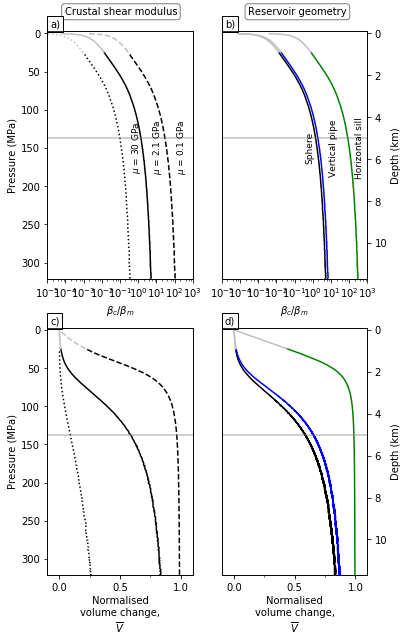

In [7]:
# plot figure

if p_space == 'H2O' or p_space == 'CO2' or p_space == 'S' or p_space == 'fO2':
    #Plot figure
    plot8_sensitivity(
        df_calc[1]['Pbar'][~np.isnan(rv1)],df_calc[2]['Pbar'][~np.isnan(rv2)],df_calc[3]['Pbar'][~np.isnan(rv3)],
        df_calc[1]['depth'][~np.isnan(rv1)],df_calc[2]['depth'][~np.isnan(rv2)],df_calc[3]['depth'][~np.isnan(rv3)],
        min_percolation1,min_percolation2,min_percolation3,res_depth,
        df_calc[1]['H2O_melt'][~np.isnan(rv1)],df_calc[1]['CO2_melt'][~np.isnan(rv1)],df_calc[1]['Stot_melt'][~np.isnan(rv1)],
        df_calc[1]['mH2Ogas'][~np.isnan(rv1)],df_calc[1]['mCO2gas'][~np.isnan(rv1)],df_calc[1]['mSO2gas'][~np.isnan(rv1)],
        df_calc[1]['mS_released'][~np.isnan(rv1)],df_calc[1]['Exsolv_vol_wt'][~np.isnan(rv1)],df_calc[1]['RhoBulk'][~np.isnan(rv1)],
        df_calc[1]['beta_bulk'][~np.isnan(rv1)],df_calc[1]['rv_bulk'][~np.isnan(rv1)],df_calc[1]['z_bulk'][~np.isnan(rv1)],
        df_calc[2]['H2O_melt'][~np.isnan(rv2)],df_calc[2]['CO2_melt'][~np.isnan(rv2)],df_calc[2]['Stot_melt'][~np.isnan(rv2)],
        df_calc[2]['mH2Ogas'][~np.isnan(rv2)],df_calc[2]['mCO2gas'][~np.isnan(rv2)],df_calc[2]['mSO2gas'][~np.isnan(rv2)],
        df_calc[2]['mS_released'][~np.isnan(rv2)],df_calc[2]['Exsolv_vol_wt'][~np.isnan(rv2)],df_calc[2]['RhoBulk'][~np.isnan(rv2)],
        df_calc[2]['beta_bulk'][~np.isnan(rv2)],df_calc[2]['rv_bulk'][~np.isnan(rv2)],df_calc[2]['z_bulk'][~np.isnan(rv2)],
        df_calc[3]['H2O_melt'][~np.isnan(rv3)],df_calc[3]['CO2_melt'][~np.isnan(rv3)],df_calc[3]['Stot_melt'][~np.isnan(rv3)],
        df_calc[3]['mH2Ogas'][~np.isnan(rv3)],df_calc[3]['mCO2gas'][~np.isnan(rv3)],df_calc[3]['mSO2gas'][~np.isnan(rv3)],
        df_calc[3]['mS_released'][~np.isnan(rv3)],df_calc[3]['Exsolv_vol_wt'][~np.isnan(rv3)],df_calc[3]['RhoBulk'][~np.isnan(rv3)],
        df_calc[3]['beta_bulk'][~np.isnan(rv3)],df_calc[3]['rv_bulk'][~np.isnan(rv3)],df_calc[3]['z_bulk'][~np.isnan(rv3)])

elif p_space == 'Crustal':
    # Amoruso & Crescentini (2009) https://doi.org/10.1029/2008JB005946
    # Poisson's ratio
    v=0.3
    # Sphere
    beta_c_sphere = 3/4/shear_modulus
    # Thin cigar-shaped spheroid, prolate
    beta_c_prolate = 1/shear_modulus 
    # Thin spheroid, oblate sill
    a_c = 100
    beta_c_oblate_Amoruso = 1/(2*shear_modulus)*(1-2*v)/(1+v)*((a_c*(4*(1-v**2))/(pi*(1-2*v)))-3)
    beta_c_oblate_Anderson = 3/shear_modulus*((a_c/2/pi)-0.2)

    # Crustal to magma compressibility ratio
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(2,4,1)
    ax2 = ax1.twinx()
    ax1.plot((((3/4/2100000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10])),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10]/10,c='k',label='$\mu$ = 2.1 GPa')
    ax1.plot((((3/4/100000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10])),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10]/10,c='k',linestyle ='dashed',label='$\mu$ = 0.1 GPa')
    ax1.plot((((3/4/30000000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10])),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10]/10,c='k',linestyle ='dotted',label='$\mu$ = 30 GPa')
    ax1.plot((((3/4/2100000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1])),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10,label='Sphere', c='silver')
    ax1.plot((((3/4/100000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1])),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10,linestyle ='dashed',label='Sphere', c='silver')
    ax1.plot((((3/4/30000000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1])),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10,linestyle ='dotted',label='Sphere', c='silver')
    ax1.set_xlabel(r'$\beta_{c}/\beta_{m}$')
    ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, df_calc[3]['Pbar'].iloc[0]/10)
    ax1.invert_yaxis()
    ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,df_calc[3]['depth'].iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    ax1.set_ylabel('Pressure (MPa)')
    ax1.set_xscale('log')
    ax2.set_yticks([])
    ax1.set_xlim(1e-5, 1e3)
    locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
    ax1.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
    ax1.xaxis.set_minor_locator(locmin)
    ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
    textstr = 'Crustal shear modulus'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax1.text(0.12, 1.1, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    textstr = 'a)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    textstr = '$\mu$ = 2.1 GPa'
    ax2.text((3/4/2100000000)/df_calc[1]['beta_bulk'].iloc[5], 4.5, textstr, fontsize=9, rotation='vertical')
    textstr = '$\mu$ = 0.1 GPa'
    ax2.text((3/4/100000000)/df_calc[1]['beta_bulk'].iloc[5], 4.5, textstr, fontsize=9, rotation='vertical')
    textstr = '$\mu$ = 30 GPa'
    ax2.text((3/4/30000000000)/df_calc[1]['beta_bulk'].iloc[5], 4.6, textstr, fontsize=9, rotation='vertical')

    # Crustal to magma compressibility ratio
    ax1 = fig.add_subplot(2,4,2)
    ax2 = ax1.twinx()
    ax1.plot((((3/4/2100000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10])),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10],label='Sphere',c='k')
    ax1.plot((((1/2100000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10])),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10],label='Vertical pipe',c='b')
    ax1.plot((((1/(2*2100000000)*(1-2*v)/(1+v)*((100*(4*(1-v**2))/(pi*(1-2*v)))-3))/df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10])),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10],label='Horizontal sill',c='g') #Amarunso
    #     ax1.legend(loc='lower left')
    ax1.plot((((3/4/2100000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1])),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1],label='Sphere', c='silver')
    ax1.plot((((1/2100000000)/df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1])),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1],label='Prolate ellipsoid', c='silver')
    ax1.plot((((1/(2*2100000000)*(1-2*v)/(1+v)*((100*(4*(1-v**2))/(pi*(1-2*v)))-3))/df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1])),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1],label='Oblate ellipsoid, a/c = 100', c='silver')#Amarunso
    ax1.set_xlabel(r'$\beta_{c}/\beta_{m}$')
    ax1.set_ylim(df_calc[3]['Pbar'].iloc[-1]-27.45, df_calc[3]['Pbar'].iloc[0])
    ax1.invert_yaxis()
    ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,df_calc[3]['depth'].iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    ax1.set_xscale('log')
    ax1.set_xlim(1e-5, 1e3)
    ax2.set_ylabel('Depth (km)')
    ax1.set_yticks([])
    locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
    ax1.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
    ax1.xaxis.set_minor_locator(locmin)
    ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
    textstr = 'Reservoir geometry'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax1.text(0.18, 1.1, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    textstr = 'b)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    textstr = 'Sphere'
    ax2.text(0.4, 5, textstr, fontsize=9, rotation='vertical')
    textstr = 'Vertical pipe'
    ax2.text(8, 4.4, textstr, fontsize=9, rotation='vertical')
    textstr = 'Horizontal sill'
    ax2.text(200, 4.3, textstr, fontsize=9, rotation='vertical')

    # Normalised volume change
    ax1 = fig.add_subplot(2, 4, 5)
    ax2 = ax1.twinx()
    ax1.plot(1/df_calc[1]['rv_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10], df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10]/10, c='k',label='$\mu$ = 2.1 GPa')
    ax1.plot(1/df_calc[2]['rv_bulk'][~np.isnan(rv2)][1:int(min_percolation2):10], df_calc[2]['Pbar'][~np.isnan(rv2)][1:int(min_percolation2):10]/10, c='k',linestyle ='dashed',label='$\mu$ = 0.1 GPa')
    ax1.plot(1/df_calc[3]['rv_bulk'][~np.isnan(rv3)][1:int(min_percolation3):10], df_calc[3]['Pbar'][~np.isnan(rv3)][1:int(min_percolation3):10]/10, c='k',linestyle ='dotted',label='$\mu$ = 30 GPa')
    ax1.plot(1/df_calc[3]['rv_bulk'][~np.isnan(rv3)][int(min_percolation3):-1], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1]/10, c='silver',linestyle ='dotted')
    ax1.plot(1/df_calc[1]['rv_bulk'][~np.isnan(rv1)][int(min_percolation1):-1], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10, c='silver')
    ax1.plot(1/df_calc[2]['rv_bulk'][~np.isnan(rv2)][int(min_percolation2):-1], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1]/10, c='silver',linestyle ='dashed')
    ax1.set_xlabel('Normalised\nvolume change,\n$\overline{V}$')
    ax1.set_ylabel('Pressure (MPa)')
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, df_calc[3]['Pbar'].iloc[0]/10)
    ax1.invert_yaxis()
    ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,df_calc[3]['depth'].iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
    ax2.set_yticks([])
    textstr = 'c)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

    # Normalised volume change
    ax1 = fig.add_subplot(2, 4, 6)
    ax2 = ax1.twinx()
    ax1.plot(1/(1+(df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1)]/beta_c_sphere)),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1)],c='k',label='Sphere')
    ax1.plot(1/(1+(df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1)]/beta_c_prolate)),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1)],c='b',label='Vertical pipe')
    ax1.plot(1/(1+(df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1)]/beta_c_oblate_Amoruso)),df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1)],c='g',label='Horizontal sill') #Amarunso
    ax1.plot(1/(1+(df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1]/beta_c_sphere)),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1], c='silver')
    ax1.plot(1/(1+(df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1]/beta_c_prolate)),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1], c='silver')
    ax1.plot(1/(1+(df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1]/beta_c_oblate_Amoruso)),df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1], c='silver') #Amarunso
    ax1.set_xlabel('Normalised\nvolume change,\n$\overline{V}$')
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_ylim(df_calc[3]['Pbar'].iloc[-1]-27.45, df_calc[3]['Pbar'].iloc[0])
    ax1.invert_yaxis()
    ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,df_calc[3]['depth'].iloc[0])
    ax2.axhline(y=res_depth, color='grey', alpha=0.5)
    ax2.invert_yaxis()
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
    ax1.set_yticks([])
    ax2.set_ylabel('Depth (km)')
    textstr = 'd)'
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

## 3. Monte-Carlo simulation <a class="anchor" id="MCSim"></a>

In [8]:
# Set parameters
magma_setting = input(f"Select volcanic setting (arc or oib): \n")

# Number of Monte-Carlo simulations
N_para = 1000

Select volcanic setting (arc or oib): 
arc


In [9]:
# Read processed simulations

dcomp_res = home_dir +  f"E_dgs_{magma_setting}_1000runs.txt"
df_calc = pd.read_csv(dcomp_res, sep='\t')
removenan = df_calc['mean_H2O_melt']

# Remove nan and filter data with less than 100 simulations
Pbar = df_calc['Pbar'][~np.isnan(removenan)]
depth = df_calc['depth'][~np.isnan(removenan)]
mean_H2O_melt = df_calc['mean_H2O_melt'][~np.isnan(removenan)]
mean_CO2_melt = df_calc['mean_CO2_melt'][~np.isnan(removenan)]
mean_S2_melt = df_calc['mean_S2_melt'][~np.isnan(removenan)]
mean_S6_melt = df_calc['mean_S6_melt'][~np.isnan(removenan)]
mean_Stot_melt = df_calc['mean_Stot_melt'][~np.isnan(removenan)]
mean_H2O_gas = df_calc['mean_H2O_gas'][~np.isnan(removenan)]
mean_CO2_gas = df_calc['mean_CO2_gas'][~np.isnan(removenan)]
mean_SO2_gas = df_calc['mean_SO2_gas'][~np.isnan(removenan)]
mean_H2S_gas = df_calc['mean_H2S_gas'][~np.isnan(removenan)]
mean_S2_gas = df_calc['mean_S2_gas'][~np.isnan(removenan)]
mean_mS_released = df_calc['mean_mS_released'][~np.isnan(removenan)]
mean_Exsolv_vol_wt = df_calc['mean_Exsolv_vol_wt'][~np.isnan(removenan)]
mean_RhoBulk = df_calc['mean_RhoBulk'][~np.isnan(removenan)]
mean_beta_bulk = df_calc['mean_beta_bulk'][~np.isnan(removenan)]
mean_rv_bulk = df_calc['mean_rv_bulk'][~np.isnan(removenan)]
mean_z_bulk = df_calc['mean_z_bulk'][~np.isnan(removenan)]
std_H2O_melt = df_calc['std_H2O_melt'][~np.isnan(removenan)]
std_CO2_melt = df_calc['std_CO2_melt'][~np.isnan(removenan)]
std_S2_melt = df_calc['std_S2_melt'][~np.isnan(removenan)]
std_S6_melt = df_calc['std_S6_melt'][~np.isnan(removenan)]
std_Stot_melt = df_calc['std_Stot_melt'][~np.isnan(removenan)]
std_H2O_gas = df_calc['std_H2O_gas'][~np.isnan(removenan)]
std_CO2_gas = df_calc['std_CO2_gas'][~np.isnan(removenan)]
std_SO2_gas = df_calc['std_SO2_gas'][~np.isnan(removenan)]
std_H2S_gas = df_calc['std_H2S_gas'][~np.isnan(removenan)]
std_S2_gas = df_calc['std_S2_gas'][~np.isnan(removenan)]
std_mS_released = df_calc['std_mS_released'][~np.isnan(removenan)]
std_Exsolv_vol_wt = df_calc['std_Exsolv_vol_wt'][~np.isnan(removenan)]
std_RhoBulk = df_calc['std_RhoBulk'][~np.isnan(removenan)]
std_beta_bulk = df_calc['std_beta_bulk'][~np.isnan(removenan)]
std_rv_bulk = df_calc['std_rv_bulk'][~np.isnan(removenan)]
std_z_bulk = df_calc['std_z_bulk'][~np.isnan(removenan)]
lowlim_mS_released = df_calc['lowlim_mS_released'][~np.isnan(removenan)]
lowlim_Exsolv_vol_wt = df_calc['lowlim_Exsolv_vol_wt'][~np.isnan(removenan)]
lowlim_rv_bulk = df_calc['lowlim_rv_bulk'][~np.isnan(removenan)]
lowlim_z_bulk = df_calc['lowlim_z_bulk'][~np.isnan(removenan)]

In [10]:
# Set reservoir depth
res_depth = float(input('\nSet reservoir depth (km):\n'))

# Set percolation threshold
min_percolation=np.where(mean_Exsolv_vol_wt == find_nearest(mean_Exsolv_vol_wt[~np.isnan(mean_Exsolv_vol_wt)], 37)) #find position of depth closest to res_depth
min_percolation=float(min_percolation[0])

# Set y axis
if magma_setting == 'arc':
    set_depth=1430
elif magma_setting == 'oib':
    set_depth=3812
print(f'\nSet yaxis depth: {depth[set_depth]} km')
print(f'Set yaxis pressure: {Pbar[set_depth]/10} MPa')


Set reservoir depth (km):
5

Set yaxis depth: 15.0 km
Set yaxis pressure: 411.6 MPa


### Figure 7

Text(0.02, 1.05, 'h)')

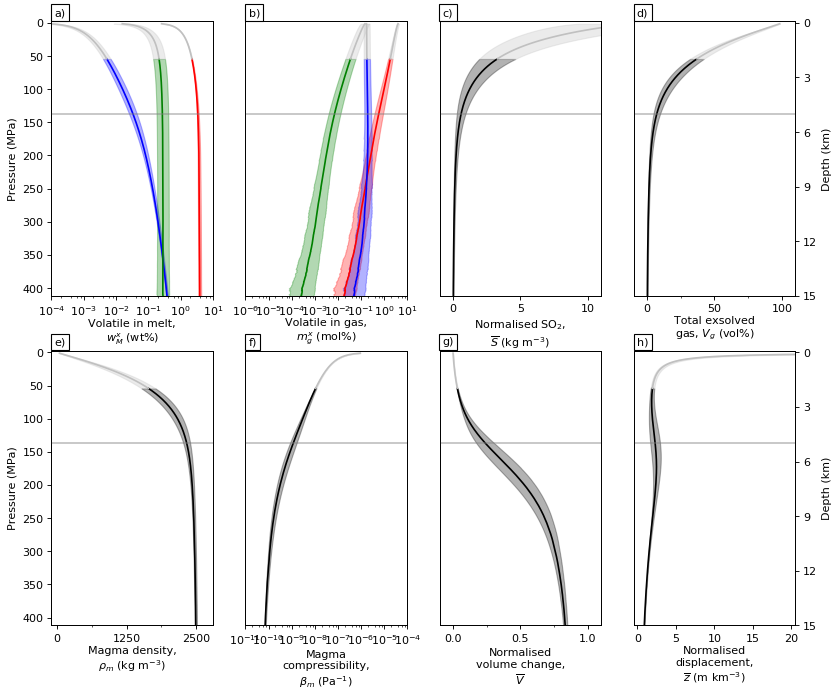

In [11]:
# plot figure
plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(2,4)

# Dissolved magmatic volatile
ax1 = plt.subplot(gs[0,0])
ax2 = ax1.twinx()
ax1.plot(np.exp(mean_H2O_melt[0:int(min_percolation):10]),Pbar[0:int(min_percolation):10]/10, color='r', linestyle = '-')
ax1.plot(np.exp(mean_H2O_melt[int(min_percolation):-1:10]),Pbar[int(min_percolation):-1:10]/10, color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10]/10, np.exp(mean_H2O_melt[0:int(min_percolation):10]-std_H2O_melt[0:int(min_percolation):10]), np.exp(mean_H2O_melt[0:int(min_percolation):10]+std_H2O_melt[0:int(min_percolation):10]), alpha=0.3, color='r')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10]/10, np.exp(mean_H2O_melt[int(min_percolation):-1:10]-std_H2O_melt[int(min_percolation):-1:10]), np.exp(mean_H2O_melt[int(min_percolation):-1:10]+std_H2O_melt[int(min_percolation):-1:10]), alpha=0.3, color='silver')
ax1.plot(np.exp(mean_CO2_melt[0:int(min_percolation):10]),Pbar[0:int(min_percolation):10]/10, color='b', linestyle = '-')
ax1.plot(np.exp(mean_CO2_melt[int(min_percolation):-1:10]),Pbar[int(min_percolation):-1:10]/10, color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10]/10, np.exp(mean_CO2_melt[0:int(min_percolation):10]-std_CO2_melt[0:int(min_percolation):10]), np.exp(mean_CO2_melt[0:int(min_percolation):10]+std_CO2_melt[0:int(min_percolation):10]), alpha=0.3, color='b')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10]/10, np.exp(mean_CO2_melt[int(min_percolation):-1:10]-std_CO2_melt[int(min_percolation):-1:10]), np.exp(mean_CO2_melt[int(min_percolation):-1:10]+std_CO2_melt[int(min_percolation):-1:10]), alpha=0.3, color='silver')
ax1.plot(np.exp(mean_Stot_melt[0:int(min_percolation):10]),Pbar[0:int(min_percolation):10]/10, color='g', linestyle = '-')
ax1.plot(np.exp(mean_Stot_melt[int(min_percolation):-1:10]),Pbar[int(min_percolation):-1:10]/10, color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10]/10, np.exp(mean_Stot_melt[0:int(min_percolation):10]-std_Stot_melt[0:int(min_percolation):10]), np.exp(mean_Stot_melt[0:int(min_percolation):10]+std_Stot_melt[0:int(min_percolation):10]), alpha=0.3, color='g')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10]/10, np.exp(mean_Stot_melt[int(min_percolation):-1:10]-std_Stot_melt[int(min_percolation):-1:10]), np.exp(mean_Stot_melt[int(min_percolation):-1:10]+std_Stot_melt[int(min_percolation):-1:10]), alpha=0.3, color='silver')
ax1.set_xlabel('Volatile in melt,\n$w^x_{M}$ (wt%)')
ax1.set_ylabel('Pressure (MPa)')
ax1.set_xlim(0.0001, 10)
ax1.set_xscale('log')
ax1.set_ylim((Pbar.iloc[-1]-27.45)/10, Pbar[set_depth]/10)
ax1.invert_yaxis()
ax2.set_ylim(depth.iloc[-1]-0.1,depth[set_depth])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2.set_yticks([])
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
textstr = 'a)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Exsolved magmatic volatile
ax1 = plt.subplot(gs[0,1])
ax2 = ax1.twinx()
ax1.plot(np.exp(mean_H2O_gas[0:int(min_percolation):10]),Pbar[0:int(min_percolation):10], color='r', linestyle = '-')
ax1.plot(np.exp(mean_H2O_gas[int(min_percolation):-1:10]),Pbar[int(min_percolation):-1:10], color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10], np.exp(mean_H2O_gas[0:int(min_percolation):10]-std_H2O_gas[0:int(min_percolation):10]), np.exp(mean_H2O_gas[0:int(min_percolation):10]+std_H2O_gas[0:int(min_percolation):10]), alpha=0.3, color='r')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10], np.exp(mean_H2O_gas[int(min_percolation):-1:10]-std_H2O_gas[int(min_percolation):-1:10]), np.exp(mean_H2O_gas[int(min_percolation):-1:10]+std_H2O_gas[int(min_percolation):-1:10]), alpha=0.3, color='silver')
ax1.plot(np.exp(mean_CO2_gas[0:int(min_percolation):10]),Pbar[0:int(min_percolation):10], color='b', linestyle = '-')
ax1.plot(np.exp(mean_CO2_gas[int(min_percolation):-1:10]),Pbar[int(min_percolation):-1:10], color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10], np.exp(mean_CO2_gas[0:int(min_percolation):10]-std_CO2_gas[0:int(min_percolation):10]), np.exp(mean_CO2_gas[0:int(min_percolation):10]+std_CO2_gas[0:int(min_percolation):10]), alpha=0.3, color='b')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10], np.exp(mean_CO2_gas[int(min_percolation):-1:10]-std_CO2_gas[int(min_percolation):-1:10]), np.exp(mean_CO2_gas[int(min_percolation):-1:10]+std_CO2_gas[int(min_percolation):-1:10]), alpha=0.3, color='silver')
ax1.plot(np.exp(mean_SO2_gas[0:int(min_percolation):10]),Pbar[0:int(min_percolation):10], color='g', linestyle = '-')
ax1.plot(np.exp(mean_SO2_gas[int(min_percolation):-1:10]),Pbar[int(min_percolation):-1:10], color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10], np.exp(mean_SO2_gas[0:int(min_percolation):10]-std_SO2_gas[0:int(min_percolation):10]), np.exp(mean_SO2_gas[0:int(min_percolation):10]+std_SO2_gas[0:int(min_percolation):10]), alpha=0.3, color='g')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10], np.exp(mean_SO2_gas[int(min_percolation):-1:10]-std_SO2_gas[int(min_percolation):-1:10]), np.exp(mean_SO2_gas[int(min_percolation):-1:10]+std_SO2_gas[int(min_percolation):-1:10]), alpha=0.3, color='silver')
ax1.set_xlabel('Volatile in gas,\n$m^x_{g}$ (mol%)')
ax1.set_xlim(0.000001, 10)
ax1.set_xscale('log')
ax1.set_ylim((Pbar.iloc[-1]-27.45), Pbar[set_depth])
ax1.invert_yaxis()
ax2.set_ylim(depth.iloc[-1]-0.1,depth[set_depth])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1.set_yticks([])
ax2.set_yticks([])
textstr = 'b)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised SO2
ax1 = plt.subplot(gs[0,2])
ax2 = ax1.twinx()
ax1.plot(mean_mS_released[0:int(min_percolation):10],Pbar[0:int(min_percolation):10], color='k', linestyle = '-')
ax1.plot(mean_mS_released[int(min_percolation):-1:10],Pbar[int(min_percolation):-1:10], color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10], lowlim_mS_released[0:int(min_percolation):10], mean_mS_released[0:int(min_percolation):10]+std_mS_released[0:int(min_percolation):10], alpha=0.3, color='k')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10], lowlim_mS_released[int(min_percolation):-1:10], mean_mS_released[int(min_percolation):-1:10]+std_mS_released[int(min_percolation):-1:10], alpha=0.3, color='silver')
ax1.set_xlabel('Normalised $\mathrm{SO_2}$,\n' + r'$\overline{S}$ (kg m$^{-3}$)')
ax1.set_ylim((Pbar.iloc[-1]-27.45), Pbar[set_depth])
ax1.invert_yaxis()
ax2.set_ylim(depth.iloc[-1]-0.1,depth[set_depth])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
# ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_xlim(-1, 11)
textstr = 'c)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Total exsolved volatiles
ax1 = plt.subplot(gs[0,3])
ax2 = ax1.twinx()
ax1.plot(mean_Exsolv_vol_wt[0:int(min_percolation):10],Pbar[0:int(min_percolation):10], color='k', linestyle = '-')
ax1.plot(mean_Exsolv_vol_wt[int(min_percolation):-1:10],Pbar[int(min_percolation):-1:10], color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10], lowlim_Exsolv_vol_wt[0:int(min_percolation):10], mean_Exsolv_vol_wt[0:int(min_percolation):10]+std_Exsolv_vol_wt[0:int(min_percolation):10], alpha=0.3, color='k')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10], lowlim_Exsolv_vol_wt[int(min_percolation):-1:10], mean_Exsolv_vol_wt[int(min_percolation):-1:10]+std_Exsolv_vol_wt[int(min_percolation):-1:10], alpha=0.3, color='silver')
ax1.set_xlabel('Total exsolved\ngas, $V_{g}$ (vol%)')
ax1.set_ylim((Pbar.iloc[-1]-27.45), Pbar[set_depth])
ax1.invert_yaxis()
ax2.set_ylim(depth.iloc[-1]-0.1,depth[set_depth])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(25))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-10, 110)
ax1.set_yticks([])
textstr = 'd)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Density
ax1 = plt.subplot(gs[1,0])
ax2 = ax1.twinx()
ax1.plot(mean_RhoBulk[0:int(min_percolation):10],Pbar[0:int(min_percolation):10]/10, color='k', linestyle = '-')
ax1.plot(mean_RhoBulk[int(min_percolation):-1:10],Pbar[int(min_percolation):-1:10]/10, color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10]/10, mean_RhoBulk[0:int(min_percolation):10]-std_RhoBulk[0:int(min_percolation):10], mean_RhoBulk[0:int(min_percolation):10]+std_RhoBulk[0:int(min_percolation):10], alpha=0.3, color='k')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10]/10, mean_RhoBulk[int(min_percolation):-1:10]-std_RhoBulk[int(min_percolation):-1:10], mean_RhoBulk[int(min_percolation):-1:10]+std_RhoBulk[int(min_percolation):-1:10], alpha=0.3, color='silver')
ax1.set_xlabel('Magma density,\n' + r'$\rho_{m}$ (kg m$^{-3}$)')
ax1.set_ylabel('Pressure (MPa)')
ax1.set_ylim((Pbar.iloc[-1]-27.45)/10, Pbar[set_depth]/10)
ax1.invert_yaxis()
ax2.set_ylim(depth.iloc[-1]-0.1,depth[set_depth])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1250))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(625))
ax1.set_xlim(-100, 2800)
ax2.set_yticks([])
textstr = 'e)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
        
# Compressibility
removezeros_beta_bulk = np.exp(mean_beta_bulk)
removezeros_beta_bulk[removezeros_beta_bulk == 0] = np.nan

ax1 = plt.subplot(gs[1,1])
ax2 = ax1.twinx()
ax1.plot(np.exp(mean_beta_bulk[0:int(min_percolation):10]),Pbar[0:int(min_percolation):10], color='k', linestyle = '-')
ax1.plot(np.exp(mean_beta_bulk[int(min_percolation):-1:10]),Pbar[int(min_percolation):-1:10], color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10], np.exp(mean_beta_bulk[0:int(min_percolation):10]-std_beta_bulk[0:int(min_percolation):10]), np.exp(mean_beta_bulk[0:int(min_percolation):10]+std_beta_bulk[0:int(min_percolation):10]), alpha=0.3, color='k')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10], np.exp(mean_beta_bulk[int(min_percolation):-1:10]-std_beta_bulk[int(min_percolation):-1:10]), np.exp(mean_beta_bulk[int(min_percolation):-1:10]+std_beta_bulk[int(min_percolation):-1:10]), alpha=0.3, color='silver')
ax1.set_xlabel('Magma\ncompressibility,\n' + r'$\beta_{m}$ (Pa$^{-1}$)')
ax1.set_xscale('log')
ax1.set_xlim(0.00000000001, 0.0001)
ax1.set_ylim((Pbar.iloc[-1]-27.45), Pbar[set_depth])
ax1.invert_yaxis()
ax2.set_ylim(depth.iloc[-1]-0.1,depth[set_depth])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1.set_yticks([])
ax2.set_yticks([])
textstr = 'f)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised volume change
ax1 = plt.subplot(gs[1,2])
ax2 = ax1.twinx()
ax1.plot(mean_rv_bulk[0:int(min_percolation):10],Pbar[0:int(min_percolation):10], color='k', linestyle = '-')
ax1.plot(mean_rv_bulk[int(min_percolation):-1:10],Pbar[int(min_percolation):-1:10], color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10], lowlim_rv_bulk[0:int(min_percolation):10], mean_rv_bulk[0:int(min_percolation):10]+std_rv_bulk[0:int(min_percolation):10], alpha=0.3, color='k')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10], lowlim_rv_bulk[int(min_percolation):-1:10], mean_rv_bulk[int(min_percolation):-1:10]+std_rv_bulk[int(min_percolation):-1:10], alpha=0.3, color='silver')
ax1.set_xlabel('Normalised\nvolume change,\n$\overline{V}$')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim((Pbar.iloc[-1]-27.45), Pbar[set_depth])
ax1.invert_yaxis()
ax2.set_ylim(depth.iloc[-1]-0.1,depth[set_depth])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax1.set_yticks([])
ax2.set_yticks([])
textstr = 'g)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised displacement
ax1 = plt.subplot(gs[1,3])
ax2 = ax1.twinx()
ax1.plot(mean_z_bulk[0:int(min_percolation):10],Pbar[0:int(min_percolation):10], color='k', linestyle = '-')
ax1.plot(mean_z_bulk[int(min_percolation):-1:10],Pbar[int(min_percolation):-1:10], color='silver', linestyle = '-')
ax1.fill_betweenx(Pbar[0:int(min_percolation):10], lowlim_z_bulk[0:int(min_percolation):10], mean_z_bulk[0:int(min_percolation):10]+std_z_bulk[0:int(min_percolation):10], alpha=0.3, color='k')
ax1.fill_betweenx(Pbar[int(min_percolation):-1:10], lowlim_z_bulk[int(min_percolation):-1:10], mean_z_bulk[int(min_percolation):-1:10]+std_z_bulk[int(min_percolation):-1:10], alpha=0.3, color='silver')
ax1.set_xlabel('Normalised\ndisplacement,\n$\overline{z}$ (m km$^{-3}$)')
ax1.set_xlim(-0.5, 20.5)
ax1.set_ylim((Pbar.iloc[-1]-27.45), Pbar[set_depth])
ax1.invert_yaxis()
ax2.set_ylim(depth.iloc[-1]-0.1,depth[set_depth])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax1.set_yticks([])
ax2.set_ylabel('Depth (km)')
textstr = 'h)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)


## 4. Observed eruptions <a class="anchor" id="Obs"></a>

### Figure 8

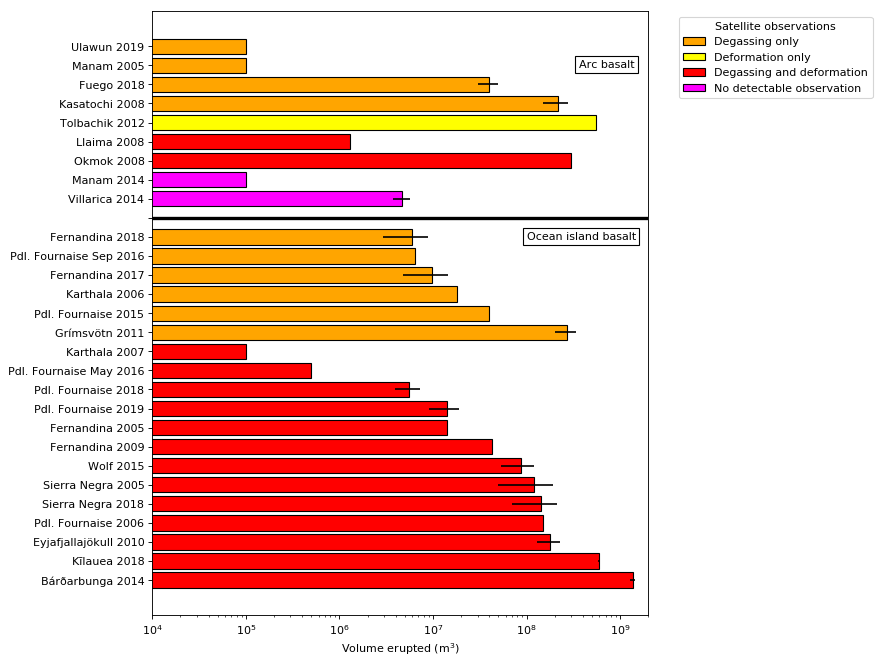

In [8]:
# Read in data

dcomp_data = home_dir + 'erupt_vol.txt'
df_k = pd.read_csv(dcomp_data, sep='\t')

defdeg = np.zeros(len(df_k['Volc_eruption']))
for i in range(len(df_k['Volc_eruption'])):
    if df_k['degas'][i]== 'n' and df_k['deform'][i] =='n':
        defdeg[i] = 0
    elif df_k['degas'][i]== 'n' and df_k['deform'][i] =='y':
        defdeg[i] = 1
    elif df_k['degas'][i]== 'y' and df_k['deform'][i] =='n':
        defdeg[i] = 2
    elif df_k['degas'][i]== 'y' and df_k['deform'][i] =='y':
        defdeg[i] = 3
    
df_k_sort = df_k.sort_values(by=['Erupted_volume'],ascending=False)
defdeg = defdeg[df_k_sort.index]

fig = plt.figure(figsize=(8, 10), dpi=80)
plt.barh(df_k_sort['Volc_eruption'][defdeg==0][df_k_sort['Volc_setting']==1],df_k_sort['Erupted_volume'][defdeg==0][df_k_sort['Volc_setting']==1], xerr = df_k_sort['Uncertainty'][defdeg==0][df_k_sort['Volc_setting']==1], color='magenta',edgecolor='k')
plt.barh(df_k_sort['Volc_eruption'][defdeg==3][df_k_sort['Volc_setting']==1],df_k_sort['Erupted_volume'][defdeg==3][df_k_sort['Volc_setting']==1], xerr = df_k_sort['Uncertainty'][defdeg==3][df_k_sort['Volc_setting']==1], color='red',edgecolor='k')
plt.barh(df_k_sort['Volc_eruption'][defdeg==1][df_k_sort['Volc_setting']==1],df_k_sort['Erupted_volume'][defdeg==1][df_k_sort['Volc_setting']==1], xerr = df_k_sort['Uncertainty'][defdeg==1][df_k_sort['Volc_setting']==1], color='yellow',edgecolor='k')
plt.barh(df_k_sort['Volc_eruption'][defdeg==2][df_k_sort['Volc_setting']==1],df_k_sort['Erupted_volume'][defdeg==2][df_k_sort['Volc_setting']==1], xerr = df_k_sort['Uncertainty'][defdeg==2][df_k_sort['Volc_setting']==1], color='orange',edgecolor='k')
plt.barh('',0)
plt.barh(df_k_sort['Volc_eruption'][defdeg==0][df_k_sort['Volc_setting']==2],df_k_sort['Erupted_volume'][defdeg==0][df_k_sort['Volc_setting']==2], xerr = df_k_sort['Uncertainty'][defdeg==0][df_k_sort['Volc_setting']==2], color='magenta',edgecolor='k')
plt.barh(df_k_sort['Volc_eruption'][defdeg==3][df_k_sort['Volc_setting']==2],df_k_sort['Erupted_volume'][defdeg==3][df_k_sort['Volc_setting']==2], xerr = df_k_sort['Uncertainty'][defdeg==3][df_k_sort['Volc_setting']==2], color='red',edgecolor='k')
plt.barh(df_k_sort['Volc_eruption'][defdeg==1][df_k_sort['Volc_setting']==2],df_k_sort['Erupted_volume'][defdeg==1][df_k_sort['Volc_setting']==2], xerr = df_k_sort['Uncertainty'][defdeg==1][df_k_sort['Volc_setting']==2], color='yellow',edgecolor='k')
plt.barh(df_k_sort['Volc_eruption'][defdeg==2][df_k_sort['Volc_setting']==2],df_k_sort['Erupted_volume'][defdeg==2][df_k_sort['Volc_setting']==2], xerr = df_k_sort['Uncertainty'][defdeg==2][df_k_sort['Volc_setting']==2], color='orange',edgecolor='k')

textstr = 'Arc basalt'
props = dict(boxstyle='square', facecolor='white', alpha=1)
plt.text(3.6e8, 27.3, textstr, fontsize=10,verticalalignment='top', bbox=props)
textstr = 'Ocean island basalt'
props = dict(boxstyle='square', facecolor='white', alpha=1)
plt.text(1e8, 18.3, textstr, fontsize=10,verticalalignment='top', bbox=props)

plt.xlabel('Volume erupted (m$^3$)')
plt.xlim(1e4,2e9)
plt.xscale("log")
plt.axhline(19,linewidth=3,color='k')

legend_elements = [Patch(facecolor='orange', edgecolor='k',
                         label='Degassing only'),
                   Patch(facecolor='yellow', edgecolor='k',
                         label='Deformation only'),
                   Patch(facecolor='red', edgecolor='k',
                         label='Degassing and deformation'),
                   Patch(facecolor='magenta', edgecolor='k',
                         label='No detectable observation')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), title="Satellite observations")

## References

- Amoruso, A., & Crescentini, L. (2009). Shape and volume change of pressurized ellipsoidal cavities from deformation and seismic data. Journal of Geophysical Research: Solid Earth, 114(B2).
- Colombier, M., Wadsworth, F. B., Scheu, B., Vasseur, J., Dobson, K. J., Cáceres, F., ... & Dingwell, D. B. (2020). In situ observation of the percolation threshold in multiphase magma analogues. Bulletin of volcanology, 82(4), 1-15.
- Gudmundsson, A. (2005). The effects of layering and local stresses in composite volcanoes on dyke emplacement and volcanic hazards. Comptes Rendus Geoscience, 337(13), 1216-1222.
- Heap, M. J., Villeneuve, M., Albino, F., Farquharson, J. I., Brothelande, E., Amelung, F., ... & Baud, P. (2020). Towards more realistic values of elastic moduli for volcano modelling. Journal of volcanology and geothermal research, 390, 106684.
- Kilbride, B. M., Edmonds, M., & Biggs, J. (2016). Observing eruptions of gas-rich compressible magmas from space. Nature Communications, 7(1), 1-8.
- Liggins, P., Shorttle, O., & Rimmer, P. B. (2020). Can volcanism build hydrogen-rich early atmospheres?. Earth and Planetary Science Letters, 550, 116546. https://doi.org/10.1016/j.epsl.2020.116546
- Liggins, P., Jordan, S., Rimmer, P. B., & Shorttle, O. (2021). Growth and evolution of secondary volcanic atmospheres: I. Identifying the geological character of warm rocky planets. arXiv preprint arXiv:2111.05161. https://doi.org/10.48550/arXiv.2111.05161
- Yip, S. T. H., Biggs, J., Edmonds, M., Liggins, P., & Shorttle, O. (2022). Reconciling volcanic deformation, degassing and petrological data using thermodynamic models. https://doi.org/10.1002/essoar.10510666.1


